In [83]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import pandas as pd
import copy
import cartopy.crs as ccrs
from sklearn.neighbors import kneighbors_graph
import itertools
from geopy import distance
import cartopy.feature as cfeature
from scipy.signal import butter, filtfilt
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
from sklearn.metrics.pairwise import haversine_distances

from math import radians

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import xesmf as xe
from cmip_basins.basins import generate_basin_codes

### INputs

In [11]:
saved_distance_matrix_bool = False
saved_distance_matrix_file_path = 'na'

#wet_path = '/work/t1a/AVISO_global_1993to2023_sla_monthly'
file_path_zos_aviso = '/work/jet/sea_level_covariability/data/zarr/AVISO_global_1994to2020_zos_monthly/'
file_path = '/work/jet/sea_level_covariability/data/zarr/CM4_historical_251_global_1850to2014_zos_monthly'

start_year, end_year = 1993, 2015

smoothing_std = 20

longitude_min, longitude_max = 0, 360
latitude_min, latitude_max = -62.5, 67.5

coarsen_factor_longitude, coarsen_factor_latitude = 20, 20

#rolling_window_ar = [12]
rolling_window = 12

a_const_dist_matrix = (2*46.51927**2)

num_clusters_arr_silo = np.arange(2,50)

num_clusters_arr = np.arange(6, 7)
num_clusters = 6
linkage_type = 'average'
linkage_ar = ['average', 'ward', 'complete', 'single']
geographic_distance, saved_geo_matrix_bool = '/work/t1a/geographic_distance_matrix_5x5_20_rolling_5.npy', False

### AHCA Clustering

In [85]:
ds = xr.open_zarr(file_path)
ds = ds.rename({'xh': 'longitude', 'yh': 'latitude'})
subset = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
subset.load()
ds_aviso = xr.open_zarr(file_path_zos_aviso)
ds_aviso = ds_aviso.rename({'xh': 'longitude', 'yh': 'latitude'})
basincodes = generate_basin_codes(ds_aviso, lon="geolon", lat="geolat", mask="wet")
basincodes_aviso_mask = (basincodes == 9) | (basincodes == 10) | (basincodes == 9) | (basincodes == 8) | (basincodes == 7) | (basincodes == 6)
ds_aviso = ds_aviso.where(~basincodes_aviso_mask).copy(deep=True)
# regridding done in this step to the cm4 hist data. This is done to make it 1 to 1 with the aviso data. This step seems most appropriate as it avoids including southern ocean
# in the spatial masking step. 
regridder = xe.Regridder(ds, ds_aviso, "bilinear")
ds_regridded = regridder(subset)

mask = ds_aviso['zos'].isel(time=-14).isnull()

subset_masked_cm4 = ds_regridded.where(~mask).copy(deep=True)
subset_masked_cm4.load()


<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 720, longitude: 1440, time: 264)
Coordinates:
    geolat     (latitude, longitude) float64 8MB -89.88 -89.88 ... 89.88 89.88
    geolon     (latitude, longitude) float64 8MB -179.9 -179.6 ... 179.6 179.9
  * time       (time) object 2kB 1993-01-16 12:00:00 ... 2014-12-16 12:00:00
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude   (latitude) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon        (latitude, longitude) float64 8MB -179.9 -179.6 ... 179.6 179.9
Data variables:
    areacello  (latitude, longitude) float32 4MB nan nan nan nan ... nan nan nan
    deptho     (latitude, longitude) float32 4MB nan nan nan nan ... nan nan nan
    wet        (latitude, longitude) float32 4MB nan nan nan nan ... nan nan nan
    zos        (time, latitude, longitude) float32 1GB nan nan nan ... nan nan
Attributes:
    regrid_method:  bilinear

In [89]:
# We use astrpoy convolve_fft to spatially smooth our data for every time step. It might be worth making sure the nans are not treated as zeros in the 
# Astropy convolve function

kernel = Gaussian2DKernel(x_stddev=smoothing_std)

for count, time_val in enumerate(subset_masked_cm4.zos.time):
    single_day_smoove = convolve_fft((subset_masked_cm4.zos.isel(time=count)), kernel)
    back_to_da = xr.DataArray(single_day_smoove, dims=("latitude", "longitude"))
    back_to_da = back_to_da.assign_coords(latitude=subset_masked_cm4.latitude, longitude=subset_masked_cm4.longitude)
    subset_masked_cm4['zos'][count] = back_to_da
    print(count)

# We then coarsen and re-mask.
subset_Coarse = subset_masked_cm4.coarsen(longitude=coarsen_factor_longitude, latitude=coarsen_factor_latitude, boundary='pad').mean().copy(deep=True)

subset_Coarse_lat_lon_slice = subset_Coarse.copy(deep=True)
subset_Coarse_lat_lon_slice['wet'] = subset_Coarse_lat_lon_slice['wet'].round()
mask = subset_Coarse_lat_lon_slice['wet'] == 1

subset_Coarse_lat_lon_slice = subset_Coarse.where(mask)

# This temporally smooths at some rolling_window amount

subset_Coarse_lat_lon_slice_initeration = subset_Coarse_lat_lon_slice.zos.rolling(time=rolling_window, center=True).mean().copy(deep=True)

# This groups, and gets keys to make haversine and correlation matrices. This code is also used for plotting 

ds_subset = subset_Coarse_lat_lon_slice_initeration.to_dataframe()
ds_dataframe_nonnan = ds_subset.dropna()

grouped_df = ds_dataframe_nonnan.groupby(['latitude', 'longitude'])
grouped_by_longitude_latitude = grouped_df.groups
keys_for_indexing = list(grouped_by_longitude_latitude.keys())

# The creation of the distance matrix. The comparison matrix is our 'distance matrix', and this is room for improvement. We should test the senstitivty to a 

n = len(grouped_by_longitude_latitude)
comparison_matrix = np.zeros((n, n), dtype=float)


geographic_matrix = (haversine_distances(np.radians(keys_for_indexing)) * 6371)
da_flat = subset_Coarse_lat_lon_slice_initeration.stack(location=('latitude', 'longitude')).transpose('location', 'time')
da_flattened = da_flat.dropna(dim='location', how='all')
r = da_flattened.to_pandas().T.corr(method='pearson')

comparison_matrix = 1-np.exp((-geographic_matrix)/(a_const_dist_matrix))*r

nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                            dims=nan_dataset_to_fill['zos'].dims)
nan_dataset_to_fill = nan_dataset_to_fill.mean(dim='time')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


### Test of Num Clusters

/vftmp/Theo.Avila/pid101814/ipykernel_116396/1786868688.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)


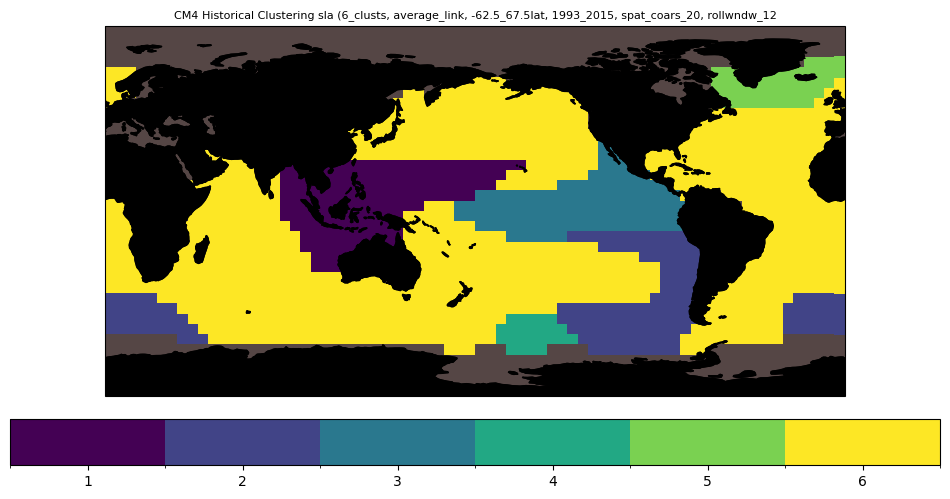

In [90]:
for num_clusters_it in num_clusters_arr:
    
    distance_matrix = comparison_matrix
    
    linkage_matrix = linkage(distance_matrix, method=linkage_type)
    
    # Extract the cluster labels
    cluster_labels = fcluster(linkage_matrix, num_clusters_it, criterion='maxclust')
    
    unique_labels = np.unique(cluster_labels)
    list_to_array_slicing = np.array(keys_for_indexing)
    
    for label in unique_labels:
        cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
        # in the code below when we index using 0 and 1 that is the array of the longitude and latitude coords. We must now put these into an xarray dataset.
        group_longitude = list_to_array_slicing[cluster_points, 1]
        group_latitude = list_to_array_slicing[cluster_points, 0]
    
        for point_iterator in range(len(group_latitude)):
            nan_dataset_to_fill.loc[{'longitude': group_longitude[point_iterator], 'latitude': group_latitude[point_iterator]}] = label
    from matplotlib.colors import ListedColormap, BoundaryNorm

    # Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
    sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
    center_value_longitude = 180
    sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude
    
    # Define the number of discrete values (clusters) you have
    
    # Create a discrete colormap
    cmap = plt.get_cmap('viridis', num_clusters_it)
    bounds = np.arange(1, num_clusters_it + 2) - .5
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Plotting the cluster map
    projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})
    
    # Plot the data
    sla_dataset_to_plot.zos.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)
    
    # Add title and extent
    ax.set_title(f'CM4 Historical Clustering sla ({num_clusters_it}_clusts, {linkage_type}_link, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spat_coars_{smoothing_std}, rollwndw_{rolling_window}', fontsize=8)
    ax.set_extent([-180, 180, -90, 90], crs=projection)
    
    # Add coastlines and features
    ax.coastlines(transform=projection)
    ax.add_feature(cfeature.LAND, zorder=10, color='black')
    ax.add_feature(cfeature.OCEAN, color='#554645')
    
    # Create colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks(np.arange(1, num_clusters_it + 1))
    cbar.set_ticklabels(np.arange(1, num_clusters_it + 1))
    
    # Save the figure
    plt.savefig(f'model_maps/2_zos_vary_cluster/CM4_historical_zos_{linkage_type}_linkage_{num_clusters_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')


### Dendrogram 

/vftmp/Theo.Avila/pid101814/ipykernel_116396/2486901899.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend), truncate_mode='lastp')


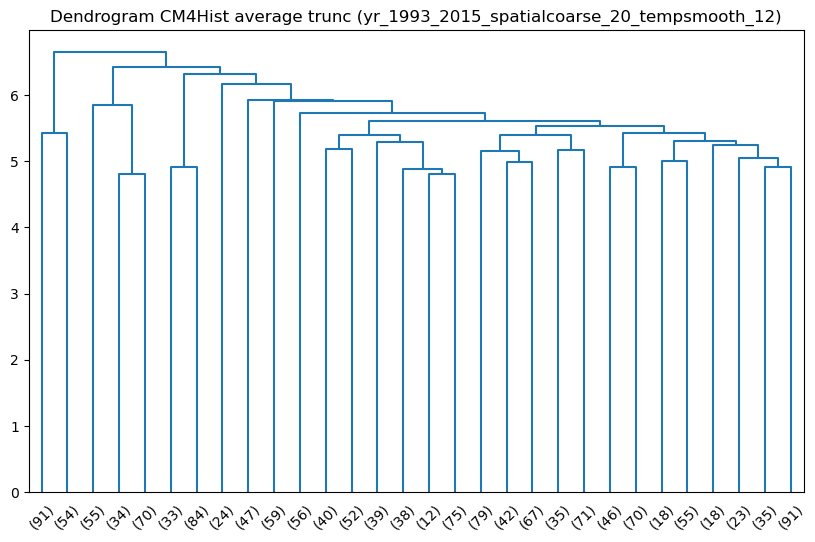

In [12]:
method_dend = 'average'

# Generate the dendrogram
dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend), truncate_mode='lastp')
#plt.ylim(0, 8)

# Change the figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # Set the desired width and height

# Add a title
plt.title(f"Dendrogram CM4Hist {method_dend} trunc (yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window})")

# Show the dendrogram
plt.savefig(f'model_maps/3_dendro/dendrogram_zos_regrid_{method_dend}_yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window}.png')

/vftmp/Theo.Avila/pid101814/ipykernel_116396/1597403023.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend))


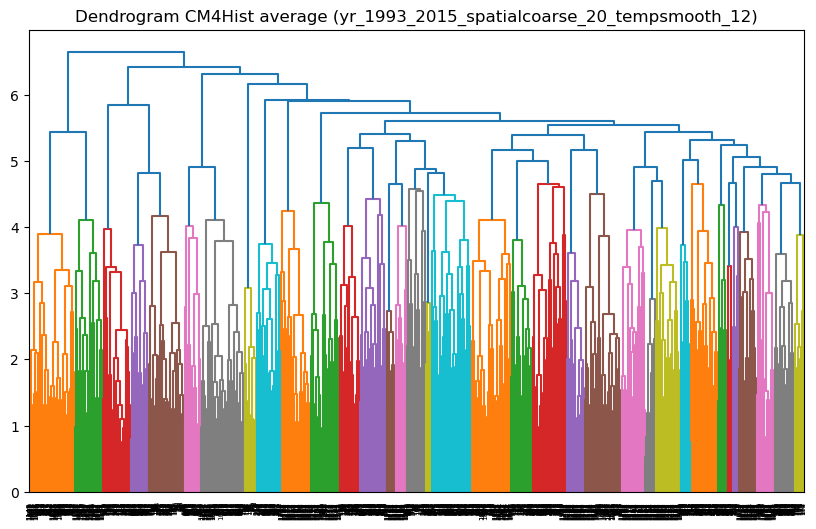

In [13]:
method_dend = 'average'

# Generate the dendrogram
dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend))
#plt.ylim(0, 8)

# Change the figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # Set the desired width and height

# Add a title
plt.title(f"Dendrogram CM4Hist {method_dend} (yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window})")

# Show the dendrogram
plt.savefig(f'model_maps/3_dendro/dendrogram_zos_regrid_nontrunc_{method_dend}_yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window}.png')

### Masking

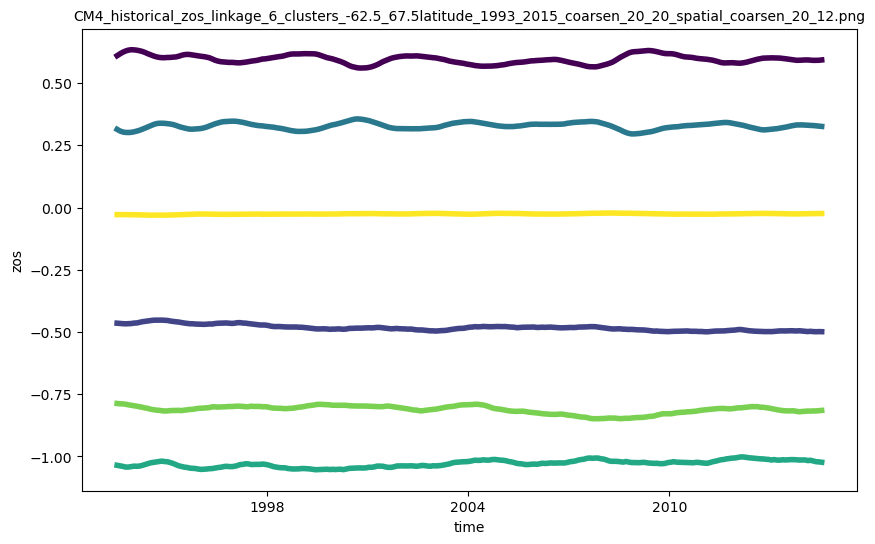

In [91]:
mask = nan_dataset_to_fill.copy(deep=True)

cmap = plt.get_cmap('viridis', len(unique_labels))
#figure = plt.figure(figsize=(10, 6))

# Grouping each cluster and plotting

each_cluster_dataset_true = []
each_cluster_dataset_false = []

for idx, cluster_val in enumerate(unique_labels):

    # Creating boolean based off of unique label, then applying so I have just the values for each cluster, could add to an array in order iterate through the others for covariance.
    boolean_mask_cluster = mask['zos'] == cluster_val
    cluster_i_masked_true = subset_Coarse_lat_lon_slice_initeration.where(boolean_mask_cluster).copy(deep=True)
    cluster_i_masked_false = subset_Coarse_lat_lon_slice_initeration.where(~boolean_mask_cluster).copy(deep=True)

    each_cluster_dataset_true.append(cluster_i_masked_true)
    each_cluster_dataset_false.append(cluster_i_masked_false)

    # Mean of each cluster in time from original. 
    cluster_i_masked_mean = cluster_i_masked_true.mean(dim=['longitude', 'latitude'])
    cluster_i_masked_mean.plot(label=f'cluster {cluster_val}', color=cmap(idx), linewidth=4)
    
#fig, ax = plt.subplots(figsize=(12, 6))
fig = plt.gcf()
fig.set_size_inches(10, 6) 
plt.title(f'CM4_historical_zos_linkage_{num_clusters_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
plt.savefig(f'model_maps/5_timeseries_for_clusters/ts_CM4_historical_zos_{linkage_type}_linkage_{num_clusters_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')
#plt.legend()
#plt.show()

In [ ]:
intra_cov_ar = []

for count, inv_cluster_true in enumerate(each_cluster_dataset_true):

    # INtra cluster variance
    da_flat_cov = inv_cluster_true.stack(location=('latitude', 'longitude')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov = da_flat_cov.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix = da_flattened_cov.to_pandas().T.cov().copy(deep=True)
    
    averaged_for_each_pt_cov = cov_matrix.mean(axis=0).copy(deep=True)
    da_flat_cov.load()
    # Unstack the data
    unstack_data = averaged_for_each_pt_cov.unstack().copy(deep=True)
    
    cluster_intra_cluster_filled = inv_cluster_true.mean(dim='time').copy(deep=True)
    cluster_intra_cluster_filled = cluster_intra_cluster_filled.fillna(np.nan)

    # Inner cluster variance now
    da_flat_cov_false = each_cluster_dataset_false[count].stack(location=('latitude', 'longitude')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov_false = da_flat_cov_false.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix_false = da_flattened_cov_false.to_pandas().T.copy(deep=True)
    da_flat_cov_false.load()
    
    for longitude in unstack_data.columns:
        # Iterate over the index values in "unstack_data"
        print(longitude)
        for latitude in unstack_data.index:
            
            # Access the specific cell in "intra_cov" using index and column values
            unstack_intra_cluster_cov = unstack_data.loc[latitude, longitude]

            unstack_data_values = da_flat_cov.loc[{'latitude': latitude, 'longitude': longitude}].values
            
            cov_matrix_false_copy_for_fill = cov_matrix_false.copy(deep=True)
            cov_matrix_false_copy_for_fill[latitude, longitude] = unstack_data_values
            cov_matrix_false_meaned = cov_matrix_false_copy_for_fill.cov().mean(axis=0)
            resultant_cov_denom_mean = cov_matrix_false_meaned[latitude, longitude]
            cluster_intra_cluster_filled.loc[latitude, longitude] = np.abs(unstack_intra_cluster_cov / resultant_cov_denom_mean)

    
    

            
    print(count)
    intra_cov_ar.append(cluster_intra_cluster_filled)

102.5
107.5
112.5
117.5
97.5
122.5
137.5
142.5
127.5
132.5
92.5
87.5
147.5
152.5
157.5
162.5
167.5
172.5
177.5
-177.5
-172.5
-167.5
-162.5
-157.5
0
-122.5
-117.5
-112.5
-107.5
-102.5
-97.5
-92.5
-87.5
-82.5
-127.5
37.5
42.5
47.5


In [ ]:

cmap_ar_div = []
matplot_color_array = ['forestgreen','gold', 'turquoise', 'orange', 'dodgerblue', 'mediumvioletred', 'peru', 'blue', 'indigo', 'violet', 'lightgreen', 'crimson', 'maroon', 'lightsalmon', 'powderblue']

for color_matplot in (matplot_color_array[0:num_clusters]):
    div_color = sns.light_palette(color_matplot, as_cmap=True)
    cmap_ar_div.append(div_color)

In [ ]:
# Plotting the cluster map
center_value_longitude=180
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

vmax_val, vmin_val = 2, .5
for cmap_it, intra_cov in enumerate(intra_cov_ar):
    intra_cov['longitude'] = intra_cov['longitude'] - 180
    intra_cov.plot(ax=ax, transform=projection, cmap=cmap_ar_div[cmap_it], add_colorbar=False, vmax=vmax_val, vmin=vmin_val)
    #intra_cov['longitude'] = intra_cov['longitude'] + 180

# Add title and extent
ax.set_title(f'CM4_Historical Clustering sla ({num_clusters}_clusters, {linkage_type}_linkage, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spatial_coarsen_{smoothing_std}, roll_window{rolling_window}, vmax_{vmax_val}', fontsize=9)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar


# Save the figure
plt.savefig(f'model_maps/4_cov_zos/CM4_Historical_zos_regrid_{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}_intra_inner_cluster_covariance_vmax_{vmax_val}.png')

### Plot Test

In [5]:
'''from matplotlib.colors import ListedColormap, BoundaryNorm

# Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
center_value_longitude = 180
sla_dataset_to_plot['xh'] = sla_dataset_to_plot['xh'] - center_value_longitude

# Define the number of discrete values (clusters) you have

# Create a discrete colormap
cmap = plt.get_cmap('viridis', num_clusters)
bounds = np.arange(1, num_clusters + 2) - .5
norm = BoundaryNorm(bounds, cmap.N)

# Plotting the cluster map
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

# Plot the data
sla_dataset_to_plot.sla.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)

# Add title and extent
ax.set_title(f'CM4 Historical Clustering sla ({num_clusters}_clusts, {linkage_type}_link, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spat_coars_{smoothing_std}, rollwndw_{rolling_window}', fontsize=8)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
cbar.set_ticks(np.arange(1, num_clusters + 1))
cbar.set_ticklabels(np.arange(1, num_clusters + 1))

# Save the figure
#plt.savefig(f'model_maps/CM4_historical_sla_{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')
'''

"from matplotlib.colors import ListedColormap, BoundaryNorm\n\n# Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)\nsla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)\ncenter_value_longitude = 180\nsla_dataset_to_plot['xh'] = sla_dataset_to_plot['xh'] - center_value_longitude\n\n# Define the number of discrete values (clusters) you have\n\n# Create a discrete colormap\ncmap = plt.get_cmap('viridis', num_clusters)\nbounds = np.arange(1, num_clusters + 2) - .5\nnorm = BoundaryNorm(bounds, cmap.N)\n\n# Plotting the cluster map\nprojection = ccrs.PlateCarree(central_longitude=center_value_longitude)\nfig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})\n\n# Plot the data\nsla_dataset_to_plot.sla.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)\n\n# Add title and extent\nax.set_title(f'CM4 Historical Clustering sla ({num_clusters}_clusts, {linka